In [33]:
from dotenv import load_dotenv
import os

try:
    print(__file__)  # 检查 __file__ 是否存在, os.path.dirname() 可以返回指定路径的父目录
    dotenv_path = os.path.join(os.path.dirname(__file__), '.env')
except NameError:
    print("Running in an interactive environment, using current directory instead.")
    # 使用 os.path.join() 和 .. 返回指定路径的父目录
    cur_work_dir = os.getcwd()
    print(cur_work_dir)
    dotenv_path = os.path.normpath(os.path.join(cur_work_dir, '.env'))
print(dotenv_path)
load_dotenv(dotenv_path, override=True)

Running in an interactive environment, using current directory instead.
/Users/ericyoung/ysx/code/github-study/langChain-rookie
/Users/ericyoung/ysx/code/github-study/langChain-rookie/.env


True

# Build a Chatbot 构建聊天机器人
- pip install langchain-core langgraph>0.2.27
- 介绍一个由LLM驱动的聊天机器人的设计和实现示例。这个聊天机器人能够进行对话并记住与聊天模型之前的交互。

In [2]:
# pip install -qU "langchain[anthropic]"
# from langchain.chat_models import init_chat_model

# model = init_chat_model("claude-3-5-sonnet-latest", model_provider="anthropic")

In [3]:
from langchain_ollama import ChatOllama

model = ChatOllama(
    model="qwen2.5:latest",
    temperature=0,
    # other params...
)
model

ChatOllama(model='qwen2.5:latest', temperature=0.0)

- 首先直接使用该模型。 ChatModel s 是 LangChain "Runnables" 的实例，这意味着它们暴露了一个标准接口以便与它们交互。
- 要简单地调用模型，我们可以将消息列表传递给 .invoke 方法。

In [4]:
from langchain_core.messages import HumanMessage

model.invoke([HumanMessage(content="Hi! I'm Bob")]).model_dump()

{'content': 'Hello Bob! Nice to meet you. How can I assist you today? Whether you have questions, need information, or just want to chat, feel free to let me know!',
 'additional_kwargs': {},
 'response_metadata': {'model': 'qwen2.5:latest',
  'created_at': '2025-02-21T15:51:47.204797Z',
  'done': True,
  'done_reason': 'stop',
  'total_duration': 4224855750,
  'load_duration': 38612625,
  'prompt_eval_count': 34,
  'prompt_eval_duration': 2498000000,
  'eval_count': 37,
  'eval_duration': 1681000000,
  'message': {'role': 'assistant',
   'content': '',
   'images': None,
   'tool_calls': None}},
 'type': 'ai',
 'name': None,
 'id': 'run-bf2e485a-51f6-4ed8-93a6-913c7f58af16-0',
 'example': False,
 'tool_calls': [],
 'invalid_tool_calls': [],
 'usage_metadata': {'input_tokens': 34,
  'output_tokens': 37,
  'total_tokens': 71}}

- 该模型本身没有任何状态的概念,没有记忆

In [5]:
model.invoke([HumanMessage(content="What's my name?")]).model_dump()

{'content': "You didn't provide your name in your question. However, you can tell me your name if you'd like me to know it! How can I assist you today?",
 'additional_kwargs': {},
 'response_metadata': {'model': 'qwen2.5:latest',
  'created_at': '2025-02-21T15:51:48.984849Z',
  'done': True,
  'done_reason': 'stop',
  'total_duration': 1757760333,
  'load_duration': 13913083,
  'prompt_eval_count': 34,
  'prompt_eval_duration': 159000000,
  'eval_count': 35,
  'eval_duration': 1582000000,
  'message': {'role': 'assistant',
   'content': '',
   'images': None,
   'tool_calls': None}},
 'type': 'ai',
 'name': None,
 'id': 'run-5f3bd608-1273-4500-8a8e-12e202b83fa8-0',
 'example': False,
 'tool_calls': [],
 'invalid_tool_calls': [],
 'usage_metadata': {'input_tokens': 34,
  'output_tokens': 35,
  'total_tokens': 69}}

- 为了克服这个问题，我们需要将整个对话历史传递给模型。

In [6]:
from langchain_core.messages import AIMessage

model.invoke(
    [
        HumanMessage(content="Hi! I'm Bob"),
        AIMessage(content="Hello Bob! How can I assist you today?"),
        HumanMessage(content="What's my name?"),
    ]
).model_dump()

{'content': "Your name is Bob. Nice to meet you, Bob! Is there anything specific you'd like to talk about or any questions you have?",
 'additional_kwargs': {},
 'response_metadata': {'model': 'qwen2.5:latest',
  'created_at': '2025-02-21T15:51:50.616748Z',
  'done': True,
  'done_reason': 'stop',
  'total_duration': 1616353875,
  'load_duration': 9173125,
  'prompt_eval_count': 59,
  'prompt_eval_duration': 297000000,
  'eval_count': 29,
  'eval_duration': 1308000000,
  'message': {'role': 'assistant',
   'content': '',
   'images': None,
   'tool_calls': None}},
 'type': 'ai',
 'name': None,
 'id': 'run-8a5bb32a-b2a0-4359-94aa-1ed6143a1105-0',
 'example': False,
 'tool_calls': [],
 'invalid_tool_calls': [],
 'usage_metadata': {'input_tokens': 59,
  'output_tokens': 29,
  'total_tokens': 88}}

## Message persistence  消息持久化
- 上述是聊天机器人具备对话能力的基本理念,如何优雅实现?
- LangGraph 实现了内置的持久层，使其非常适合支持多轮对话的聊天应用。
- 将聊天模型封装在最小化 LangGraph 应用程序中，可以使我们自动保存消息历史记录，简化多轮对话应用的开发。
- LangGraph 随附了一个简单的内存中检查点工具, 具体还有其他,包括如何使用不同的持久化后端（例如，SQLite 或 Postgres）。

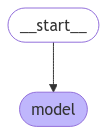

In [7]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph

# Define a new graph
workflow = StateGraph(state_schema=MessagesState)


# Define the function that calls the model
def call_model(state: MessagesState):
    response = model.invoke(state["messages"])
    return {"messages": response}


# Define the (single) node in the graph
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

# Add memory
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)
app

- 单个应用程序支持多个对话线程，这是当您的应用程序有多名用户时的一个常见要求。

In [8]:
config = {"configurable": {"thread_id": "historyId_001"}}

- 多轮对话

In [9]:
query = "Hi! I'm Bob."

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()  # output contains all messages in state

================================== Ai Message ==================================

Hello Bob! Nice to meet you. How can I assist you today? Whether you have questions, need information, or just want to chat, feel free to let me know!


In [10]:
query = "What's my name?"

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Your name is Bob!


- 多用户

In [11]:
config = {"configurable": {"thread_id": "abc234"}}

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

You didn't provide your name in your question. However, you can tell me your name if you'd like me to know it! How can I assist you today?


- 回到第一个对话

In [12]:
config = {"configurable": {"thread_id": "historyId_001"}}

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Your name is Bob. How can I assist you further with that information?


## 异步操作 .ainvoke
- 为了支持异步操作，请将 call_model 节点更新为异步函数，并在调用应用程序时使用 .ainvoke ：

In [13]:
# Async function for node:
async def call_model(state: MessagesState):
    response = await model.ainvoke(state["messages"])
    return {"messages": response}


# Define graph as before:
workflow = StateGraph(state_schema=MessagesState)
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)
app = workflow.compile(checkpointer=MemorySaver())

# Async invocation:
output = await app.ainvoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

You didn't provide your name in your question. However, you can tell me your name if you'd like me to know it! How can I assist you today?


## Prompt templates  提示模板
- 通过添加提示模板，我们可以使聊天机器人更加复杂和个性化
- Prompt Templates 帮助将原始用户信息转换成 LLM 可以处理的格式。
- 在这种情况下，原始用户输入只是一个消息，我们将其传递给 LLM。现在让我们使其稍微复杂一些。
- 首先，我们添加一个包含一些**自定义指令的系统消息**（但仍以消息作为输入）。
- 接下来，我们将添加更多的输入，而不仅仅是消息。

### 添加系统信息
- 添加一个系统消息，我们将创建一个 ChatPromptTemplate 。我们将利用 MessagesPlaceholder 来传递所有消息

In [14]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You talk like a pirate. Answer all questions to the best of your ability.",
        ),
        MessagesPlaceholder(variable_name="messages"), # 会找到messages变量的值来替代,
    ]
)

- 应用到call_model中

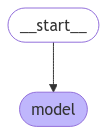

In [15]:
workflow = StateGraph(state_schema=MessagesState)


def call_model(state: MessagesState):
    prompt = prompt_template.invoke(state)
    response = model.invoke(prompt)
    return {"messages": response}


workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)
app

In [16]:
config = {"configurable": {"thread_id": "abc345"}}
query = "Hi! I'm Jim."

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Ahoy, matey! I be Captain Jack Sparrow from th' seven seas. What bring thee t' speak with ol' Jack today? Be ye seekin' directions t' th' nearest piece o' land or perhaps ye be in need of a swashbucklin' adventure?


In [17]:
query = "What is my name?"

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Thy name be Jim, matey! Or so thou saidst yar just now. How can I assist thee further, Jim? Be ye planning a voyage or perhaps seekin' some treasure?


### 让提示词更复杂些
- 在提示中添加了一个新的 language 输入。现在我们的应用程序有两个参数——输入 messages 和 language 。我们应该更新应用程序的状态以反映这一点

In [18]:
prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant. Answer all questions to the best of your ability in {language}.",
        ),
        MessagesPlaceholder(variable_name="messages"), # 会找到messages变量的值来替代,
    ]
)

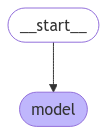

In [19]:
from typing import Sequence

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from typing_extensions import Annotated, TypedDict


class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    language: str


workflow = StateGraph(state_schema=State)


def call_model(state: State):
    prompt = prompt_template.invoke(state)
    response = model.invoke(prompt)  # llm
    return {"messages": [response]}


workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)
app

In [20]:
config = {"configurable": {"thread_id": "abc456"}}
query = "Hi! I'm Bob."
language = "Chinese"

input_messages = [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "language": language},
    config,
)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

你好！我是Bob，很高兴认识你。你可以告诉我一些你想讨论的问题或者话题吗？


- 整个状态都会被保存，因此如果不需要任何更改，我们可以省略参数如 language
- 再一次对话

In [21]:
query = "What is my name?"

input_messages = [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages},
    config,
)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

你的名字是Bob。


## Managing Conversation History 管理对话历史
- 构建聊天机器人时理解的一个重要概念是如何管理对话历史。如果不加以管理，消息列表将无限制地增长，并且可能会溢出LLM的内容窗口。
- 因此，重要的是要添加一个**限制您传递的消息大小**的步骤。
- 应在加载消息历史中的先前消息之后，但在提示模板之前进行此操作
- LangChain 随附了一些用于管理消息列表的内置助手。在这种情况下，我们将使用 trim_messages 助手来减少发送给模型的消息数量。
    - 修剪器允许我们指定要保留的令牌数量，以及其他参数，例如是否始终保留系统消息，以及是否允许部分消息。

### 裁剪

In [23]:
from langchain_core.messages import SystemMessage, trim_messages

trimmer = trim_messages(
    max_tokens=65,
    strategy="last",
    token_counter=model,
    include_system=True,
    allow_partial=False,
    start_on="human",
)

messages = [
    SystemMessage(content="you're a good assistant"),
    HumanMessage(content="hi! I'm bob"),
    AIMessage(content="hi!"),
    HumanMessage(content="I like vanilla ice cream"),
    AIMessage(content="nice"),
    HumanMessage(content="whats 2 + 2"),
    AIMessage(content="4"),
    HumanMessage(content="thanks"),
    AIMessage(content="no problem!"),
    HumanMessage(content="having fun?"),
    AIMessage(content="yes!"),
]

trimmer.invoke(messages)

[SystemMessage(content="you're a good assistant", additional_kwargs={}, response_metadata={}),
 HumanMessage(content="hi! I'm bob", additional_kwargs={}, response_metadata={}),
 AIMessage(content='hi!', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='I like vanilla ice cream', additional_kwargs={}, response_metadata={}),
 AIMessage(content='nice', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='whats 2 + 2', additional_kwargs={}, response_metadata={}),
 AIMessage(content='4', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='thanks', additional_kwargs={}, response_metadata={}),
 AIMessage(content='no problem!', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='having fun?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='yes!', additional_kwargs={}, response_metadata={})]

- 要在我们的链中使用它，我们只需要在将 messages 输入传递给提示之前运行 trimmer。

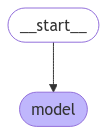

In [24]:
workflow = StateGraph(state_schema=State)


def call_model(state: State):
    trimmed_messages = trimmer.invoke(state["messages"])
    prompt = prompt_template.invoke(
        {"messages": trimmed_messages, "language": state["language"]}
    )
    response = model.invoke(prompt)
    return {"messages": [response]}


workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)
app

- 现在如果我们问模型我们的名字，它不会知道，因为我们将聊天记录的那部分剪掉了：

In [25]:
config = {"configurable": {"thread_id": "abc567"}}
query = "What is my name?"
language = "English"

input_messages = messages + [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "language": language},
    config,
)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Your name is Bob.


- 但如果我们询问最近几条消息中的信息，它会记住：

In [26]:
config = {"configurable": {"thread_id": "abc678"}}
query = "What math problem did I ask?"
language = "English"

input_messages = messages + [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "language": language},
    config,
)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

You asked, "What math problem did I ask?" The math problem you asked about was "2 + 2." The answer is 4. Is there anything else you'd like to know or discuss?


## Streaming  流式
- 聊天机器人应用中一个非常重要的用户体验考虑因素是流式传输。
- LLMs有时需要一些时间来响应，因此为了改善用户体验，大多数应用会在生成每个词元时将其流式传输回给用户。这可以让用户看到进度。
- 默认情况下，在我们的 LangGraph 应用程序中， .stream 流式传输应用程序步骤——在这种情况下，模型响应的单一步骤。
    - 设置 stream_mode="messages" 允许我们流式传输输出标记：

In [29]:
config = {"configurable": {"thread_id": "abc789"}}
query = "Hi I'm Todd, please tell me a joke."
language = "English"

input_messages = [HumanMessage(query)]
for chunk, metadata in app.stream(
    {"messages": input_messages, "language": language},
    config,
    stream_mode="messages",
):
    if isinstance(chunk, AIMessage):  # Filter to just model responses
        print(chunk.content, end="|")

Sure|,| Todd|!| Here|'s| a| light|-hearted| joke| for| you|:

't| scientists| trust| atoms|?

Because| they| make| up| everything|!||